In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

class NeuralNetwork(object):
    def __init__(self,iL_s, oL_s, hL_n, hL_s, iActFunc, hActFunc,reg, learningRate, toStop, stopSize):
        #layer sizes:
        self.inputLayerSize = iL_s;
        self.outputLayerSize = oL_s;
        self.hiddenLayers = hL_n;
        self.hiddenLayerSize = hL_s;
        #wheight intialization, using Xavier initailization:
        self.W = []
        self.W.append(np.random.randn(self.inputLayerSize, self.hiddenLayerSize[0])/np.sqrt(self.inputLayerSize/2.0));
        for i in range(self.hiddenLayers-1):
            self.W.append(np.random.randn(self.hiddenLayerSize[i], self.hiddenLayerSize[i+1])/np.sqrt(self.hiddenLayerSize[i]/2.0));
        self.W.append(np.random.randn(self.hiddenLayerSize[-1], self.outputLayerSize)/np.sqrt(self.hiddenLayerSize[-1]/2.0));  
       
        #bais intialization
        self.b = [];
        self.b.append(np.random.randn(1, self.hiddenLayerSize[0])/np.sqrt(self.inputLayerSize/2.0));
        for i in range(self.hiddenLayers-1):
            self.b.append(np.random.randn(1, self.hiddenLayerSize[i+1])/np.sqrt(self.hiddenLayerSize[i]/2.0));
        self.b.append(np.random.randn(1, self.outputLayerSize)/np.sqrt(self.hiddenLayerSize[-1]/2.0));  
        
        #choosing activation function:
        self.inputActivationFunction = iActFunc;
        self.hiddenActivationFunction = hActFunc;
        #output activation is set to be softmax for the ease of using NLL
        #adding hyperparameters
        self.reg = reg;
        self.alpha = learningRate;
        #loss history intialization:
        self.toStop = toStop;
        self.stopSize = stopSize;
        self.stopNow = False;
        if(self.toStop):
            self.lossHist = np.zeros(self.stopSize);
            self.lossHist[self.lossHist == 0] = np.inf; 
        ##### this is used to store the weight set that produced the best result
        self.BW = self.W;
        self.Bb = self.b;
    ###########################
    def relu(self, x):    #relu activation function
        x[x<=0] = 0;
        return x;
    
    def sigmoid(self,x):  #sigmoid activation function
        return 1/(1+np.exp(-x));
    
    def tanh(self, x):    # tanh activation function
        return np.tanh(x);
    
    def elu(self, x):     #elu activation function
        x[x<=0] = self.alpha * (np.exp(x[x<=0])-1);
        return x;
 
    def softmax(self,x):  #softmax implementation
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True));   # here we subtract the maximum value to avoid the overflow
        
        probs = exp_x / (np.sum(exp_x, axis=1, keepdims=True)); #softmax process
        
        return probs;
     
        
   ####################################     
    def forward(self, x):
        self.a = [];  #array to store output of activation layers
        self.t = [];  #array to store output of linear parts
        self.t.append(np.dot(x, np.array(self.W[0])) + np.array(self.b[0]))  # calculate the linear part of the input layer
        
        
        #based on the activation type go through the activation
        if(self.inputActivationFunction =='relu'):
            self.a.append(self.relu(np.array(self.t[0])))
        elif(self.inputActivationFunction =='sigmoid'):
            self.a.append(self.sigmoid(np.array(self.t[0])))
        elif(self.inputActivationFunction =='elu'):
            self.a.append(self.elu(np.array(self.t[0])))
        elif(self.inputActivationFunction =='tanh'):
            self.a.append(self.tanh(np.array(self.t[0])))
        else: #if no activation is used on the input
            self.a.append(self.t[0]);
        
        #go through the hidden layers repeating the same process
        for i in range (1, self.hiddenLayers+1):
            self.t.append(np.dot(np.array(self.a[i-1]), np.array(self.W[i]))+np.array(self.b[i]))
            #use the activation functions for hidden layers unless you reach the output layer
            if (i != self.hiddenLayers):
                if(self.hiddenActivationFunction =='relu'):
                    self.a.append(self.relu(np.array(self.t[i])));
                elif(self.hiddenActivationFunction =='sigmoid'):
                    self.a.append(self.sigmoid(np.array(self.t[i])));
                elif(self.hiddenActivationFunction =='elu'):
                    self.a.append(self.elu(np.array(self.t[i])));
                elif(self.hiddenActivationFunction =='tanh'):
                    self.a.append(self.tanh(np.array(self.t[0])))
                else: 
                    self.a.append(self.t[0]);
        #apply softmax on the output layer
        self.yHat = self.softmax(np.array(self.t[-1]));
        
       
  
    ###################################3     
    def loss(self, y, Test):  
        #loss calculation
        n = self.yHat.shape[0]
        data_loss = -np.sum(np.log(self.yHat[np.arange(n), y]+1e-9)) / n #negative log likelihood
        #reguralization loss
        reg_loss = 0
        for i in range(len(self.W)):
            reg_loss += 0.5*self.reg*np.sum(self.W[i]*self.W[i]);  
        loss = data_loss + reg_loss  
        
        if (Test):   #if you're testing; don't account for regularization
            return data_loss;
        else:      #else account for it
            return loss;

    def sigmoidDerivative(self,x): #derivative of sigmoid activation
        return np.exp(-x)/((1+np.exp(-x))**2)
    
    def reluDerivative(self,x):   #derivative of relu activation
        x[x<=0] = 0
        x[x>0] = 1
        return x

    def eluDerivative(self, x):  #derivative of elu activation
        x[x<0] = self.alpha * (np.exp(x[x<0]));
        x[x>0] = 1;
        return x;
 
    def tanhDerivative(self,x):  #derivative of tanh activation
        return 1.0 - np.tanh(x)**2
    
    ##################################
    def backward(self, x, y):
        n = y.shape[0]
        #calculate the derivative for softmax and NLL;
        dscores = self.yHat;
        dscores[range(n),y] -= 1
        dscores /= n

        dw = []
        db = []
        dhidden = dscores
        
        
        #back probagate through the output layer calculating the first gradient of weights
        dw.append(np.dot(np.array(self.a[-1]).T, dscores))
        db.append(np.sum(dscores, axis=0, keepdims=True));             
        #back probagate through the neural network
        for i in range (1, len(self.W)):
                #calculate the gradient
                dhidden = np.dot(dhidden, np.array(self.W[0-i]).T)
                    
                if (i == len(self.W)-1):#if we reached input layer
                    #go through input layer activation
                    if(self.inputActivationFunction =='relu'):
                        dhidden = np.multiply(dhidden , self.reluDerivative(self.a[-i]));
                    elif(self.inputActivationFunction =='sigmoid'):
                        dhidden = np.multiply(dhidden , self.sigmoidDerivative(self.a[-i]));
                    elif(self.inputActivationFunction =='elu'):
                        dhidden = np.multiply(dhidden , self.eluDerivative(self.a[-i]));
                    elif(self.inputActivationFunction =='tanh'):
                        dhidden = np.multiply(dhidden , self.tanhDerivative(self.a[-i]));
                    #calculate the gradient of the weight and the bais
                    dw.append(np.dot(x.T, dhidden))
                    db.append(np.sum(dhidden, axis=0, keepdims=True))
                else: #if not
                    #go through hidden layers activation
                    if(self.hiddenActivationFunction =='relu'):
                        dhidden = np.multiply(dhidden , self.reluDerivative(self.a[-i]));
                    elif(self.hiddenActivationFunction =='sigmoid'):
                        dhidden = np.multiply(dhidden , self.sigmoidDerivative(self.a[-i]));
                    elif(self.hiddenActivationFunction =='elu'):
                        dhidden = np.multiply(dhidden , self.eluDerivative(self.a[-i]));
                    elif(self.hiddenActivationFunction =='tanh'):
                        dhidden = np.multiply(dhidden , self.tanhDerivative(self.a[-i]));
                    #calculate the gradient of the weight and the bais
                    dw.append(np.dot(np.array(self.a[-1-i]).T, dhidden))
                    db.append(np.sum(dhidden, axis=0, keepdims=True))
                    
        #add the reguralization gradient   
        for i in range (0, len(dw)):
            dw[i] += self.reg * self.W[-1-i]
       
        return dw, db; 

    
    
    ############################################
    def trainbatch(self, x,y): #training a single batch
        #go forward
        self.forward(x);
        #calculate the loss
        loss = self.loss(y,False);
        #go backward
        dw, db = self.backward(x, y);
        #update the weights using SGD
        for j in range(len(self.W)):
            self.W[j] = np.array(self.W[j]) - self.alpha*np.array(dw[0-j-1]);
            self.b[j] = np.array(self.b[j]) - self.alpha*np.array(db[0-j-1]);           
        
        
         #check the predicted class for accuracy calculation
        predicted_class = np.argmax(self.yHat, axis=1)
        cnt = 0
        for i in range (0, len(y)):
            if (y[i] == predicted_class[i]):#if correctly classified
                cnt += 1 #add 1
        return (cnt/float(len(x))),loss #return the accuracy and loss for this batch
        
    #####################################################
    def validate(self, x, y): #validate during the training
        #go forward
        self.forward(x);
        #calculate the data loss
        loss = self.loss(y, True);
         #check the predicted class for accuracy calculation
        predicted_class = np.argmax(self.yHat, axis=1)
        cnt = 0
        for i in range (0, len(y)):
            if (y[i] == predicted_class[i]):#if correctly classified
                cnt += 1;#add 1
        return  (cnt/float(len(x))),loss #return the accuracy and loss for this set
    
    
    
    ###########################################################
    
    def stopE(self,loss): #force stop logic
        #initialize a probablity array of zeros
        probs = np.zeros(self.stopSize)
        #loop over the cached loss history and for each loss data that is less than the current loss make the probability of stop 1
        probs[self.lossHist < loss] = 1;
        #save the current loss into the array
        self.lossHist[:-1] = self.lossHist[1:];
        self.lossHist[-1] = loss;
        
        if(np.mean(probs) > 0.8):#if more 80% of the previous losses are less than the current loss
            if(self.stopNow): # if you already faced a similar situation in the previous iteration
                return True; #stop the training
            else: #if not
                self.stopNow = True; #record the incident 
                return False;      #don't stop the training now
        else:
            self.stopNow = False; #disregard previous alarms
            return False; #don't stop the training
            
        
    ###########################################################
    def train(self, x, y, epoch = 1000, batchSize = 128, validation = 1000):
        #decide how many batches do you have based on the batchsize and input size 
        y = np.array(y);
        batchN = (len(x)-validation)/batchSize; #leave out a part for validation
        bestAcc = 0; # to record the best validation Acc. achieved 
        #prepare for the epoch Vs loss graph
        plt.ion();
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        #loop over the epochs
        for i in range (epoch):
            acc = 0  #reset accuracy
            loss = 0 #reset loss
            
            #loop over the batches
            for k in range (batchN):
                #train
                tmp1, tmp2 = self.trainbatch(x[k*batchSize:(k+1)*batchSize],y[k*batchSize:(k+1)*batchSize]); 
                acc += tmp1 #accumulate accuracy
                loss += tmp2 #accumulate loss
                
            #record loss and accuracy of the validation set
            vAcc, vLoss = self.validate(x[len(x)-validation:],y[len(y)-validation:]);
            
            #add to the plot
            plt.plot(i, loss/float(batchN), 'k', marker = '^')
            plt.plot(i, vLoss, 'b', marker = 'o')
            #printing givens on the current epoch
            print("epoch: ", i, "Tr. loss: ", (loss/float(batchN)), "Tr. Acc: ", (acc/float(batchN))*100, "%", "Val. Loss: ", vLoss,"Val. Acc: ", vAcc*100,"%")
            
            #check if this configuration has achieved a higher accuracy than before
            if(vAcc*100 >= bestAcc):
                #record the configuration for future use
                bestAcc = vAcc*100;
                self.BW = self.W;
                self.Bb = self.b
                
            #check if we should stop the training now
            if((self.toStop == True) and (self.stopE(vLoss) == True) and (self.stopNow == True)):
                break;
            
    ##############################################
    def test(self, x, y):
        #make the weights and baises as the best recorded by the training
        self.W = self.BW;
        self.b = self.Bb;
        #forward
        self.forward(x);
        #calculate data loss
        loss = self.loss(y, True);
        
        #calculate the accuracy
        predicted_class = np.argmax(self.yHat, axis=1)
        cnt = 0
        for f in range (0, len(y)):
            if (y[f] == predicted_class[f]):
                cnt += 1;
        print("test data - loss: ", loss, "Acc: ", (cnt/float(len(x)))*100, "%");
        return loss, ((cnt/float(len(x)))*100)
    
    ##########################################
    def testPerClass(self,x,y, classes):
       #make the weights and baises as the best recorded by the training
        self.W = self.BW;
        self.b = self.Bb;
        #go forward
        self.forward(x);
        #calculate loss
        loss = self.loss(y, True);
        
        #calculate the accuracy for each class 
        predicted_class = np.argmax(self.yHat, axis=1)
        corr = np.zeros(classes);
        for f in range (0, len(y)):
            if (y[f] == predicted_class[f]):
                corr[predicted_class[f]] += 1;
        #printing the class accuracy
        for i in range (len(corr)):
            print ("class: ", i, " acc: ", (corr[i]/(len(y)/classes))*100);
        
    #############################################
    def printBW(self): #this is used to return the best weight and bais, to use it to continue the training where it stopped
        return self.BW, self.Bb;
    
    ############################################
    def initW(self, NW, Nb): #re-initializing the weights to continue the training when it stops
        self.W = NW;
        self.b = Nb;

In [2]:
def unpickle(file):
    import cPickle
    with open(file, 'rb') as fo:
        dict = cPickle.load(fo)
    return dict

In [3]:
#reading the training data file
file = "train";
dict = unpickle(file); 

In [4]:
#extracting the data and labels from the dictionary
Darr = dict['data'];
Larr = dict['coarse_labels'];

In [5]:
#reding the test data
file = "test";
dict = unpickle(file); #reading test data

In [6]:

Tarr = dict['data']; #reading input data
TLarr = dict['coarse_labels']; #reading input labels

3072
50000
('epoch: ', 0, 'Tr. loss: ', 19.79082596170079, 'Tr. Acc: ', 12.293750000000001, '%', 'Val. Loss: ', 2.7847243846777716, 'Val. Acc: ', 15.35, '%')
('epoch: ', 1, 'Tr. loss: ', 19.356888752645283, 'Tr. Acc: ', 18.795833333333334, '%', 'Val. Loss: ', 2.658544094332248, 'Val. Acc: ', 18.6, '%')
('epoch: ', 2, 'Tr. loss: ', 19.125207998531145, 'Tr. Acc: ', 21.847916666666666, '%', 'Val. Loss: ', 2.5874760530096563, 'Val. Acc: ', 21.15, '%')
('epoch: ', 3, 'Tr. loss: ', 18.93235690770558, 'Tr. Acc: ', 23.939583333333335, '%', 'Val. Loss: ', 2.5402960746410344, 'Val. Acc: ', 22.35, '%')
('epoch: ', 4, 'Tr. loss: ', 18.758700347701595, 'Tr. Acc: ', 25.414583333333336, '%', 'Val. Loss: ', 2.5058147861244553, 'Val. Acc: ', 23.5, '%')
('epoch: ', 5, 'Tr. loss: ', 18.596666937967058, 'Tr. Acc: ', 26.739583333333332, '%', 'Val. Loss: ', 2.479795694450898, 'Val. Acc: ', 24.2, '%')
('epoch: ', 6, 'Tr. loss: ', 18.442472081822167, 'Tr. Acc: ', 27.835416666666667, '%', 'Val. Loss: ', 2.4582

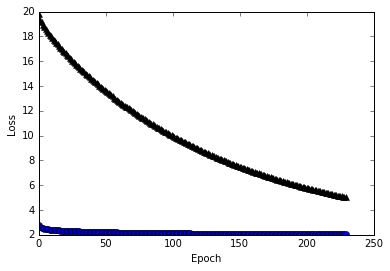

In [8]:
#training data preprocessing

Darr = Darr - np.mean(Darr, axis=0) #zero centering the data
Darr = Darr / np.std(Darr, axis=0)  #normalizing the data

#test data preprocessing
Tarr = Tarr - np.mean(Tarr, axis=0) #zero centering the data
Tarr = Tarr / np.std(Tarr, axis=0) #normalizing the data

#the random seed used
np.random.seed(7);
#the architecture as follows: inputSize = 3072, outputSize = 20, Number of Hidden Layers = 4, the Hidden layer sizes = [1024,512,256,128], the input activation layer = 'relu',the hidden layer activation = 'relu', reg = 0.01, learnning Rate = 0.001, ToStop = True, Loss history cache 
nn = NeuralNetwork(Darr[0].shape[0],20,3,[1024,512,128],'relu','relu',0.01,0.001,True, 5);


nn.train(Darr,Larr,400,128,2000); #training(inputData, Labels, Epochs, batchSize, Validation set size);
nn.test(Tarr, TLarr); #training(inputData, Labels);
nn.testPerClass(Tarr,TLarr,20);  #training(inputData, Labels, number of classes);